### Домашнее задание 04

1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. сделать разбиение набора данных не тренировочную и тестовую выборки
4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями
6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей
7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('data.csv')
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0


In [3]:
df.rename(columns = {'offer':'treatment', 'conversion':'target'}, inplace = True)
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0


In [4]:
df['treatment'].value_counts(), df['target'].value_counts()

(Buy One Get One    21387
 Discount           21307
 No Offer           21306
 Name: treatment, dtype: int64,
 0    54606
 1     9394
 Name: target, dtype: int64)

In [5]:
df['treatment'].replace(('Buy One Get One', 'Discount', 'No Offer'), (1, 1, 0), inplace=True)
df['treatment'].value_counts()

1    42694
0    21306
Name: treatment, dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   treatment      64000 non-null  int64  
 8   target         64000 non-null  int64  
dtypes: float64(1), int64(6), object(2)
memory usage: 4.4+ MB


In [7]:
X = pd.get_dummies(df)
X.drop('target', axis=1, inplace=True)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [8]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel, ClassTransformation, TwoModels
from catboost import CatBoostClassifier

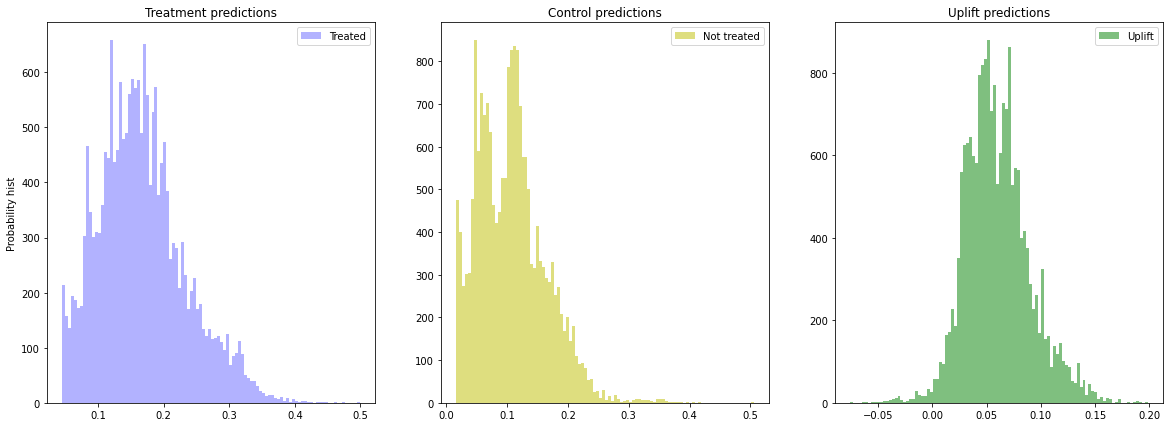

In [9]:
models_results = {
    'name': [],
    'uplift@10%': [],
    'uplift@20%': []
}

treat_train = X_train.treatment
treat_test = X_test.treatment

sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train)

uplift_sm = sm.predict(X_test)

sm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.1)
sm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.2)

models_results['name'].append('SoloModel')
models_results['uplift@10%'].append(sm_score_10)
models_results['uplift@20%'].append(sm_score_20)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [10]:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,is_referral,18.226424
1,treatment,17.000395
2,history,13.439344
3,recency,12.300206
4,used_bogo,11.425274
5,used_discount,7.505897
6,zip_code_Rural,7.460320
7,channel_Web,4.784446
8,channel_Phone,4.678400
9,zip_code_Surburban,2.068725


In [11]:
# модель с транформацией таргета
ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train)

uplift_ct = ct.predict(X_test)

ct_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.1)
ct_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.2)

models_results['name'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score_10)
models_results['uplift@20%'].append(ct_score_20)

models_results

{'name': ['SoloModel', 'ClassTransformation'],
 'uplift@10%': [0.09272573404959894, 0.24892928103613216],
 'uplift@20%': [0.0912031091481412, 0.1929005127765024]}

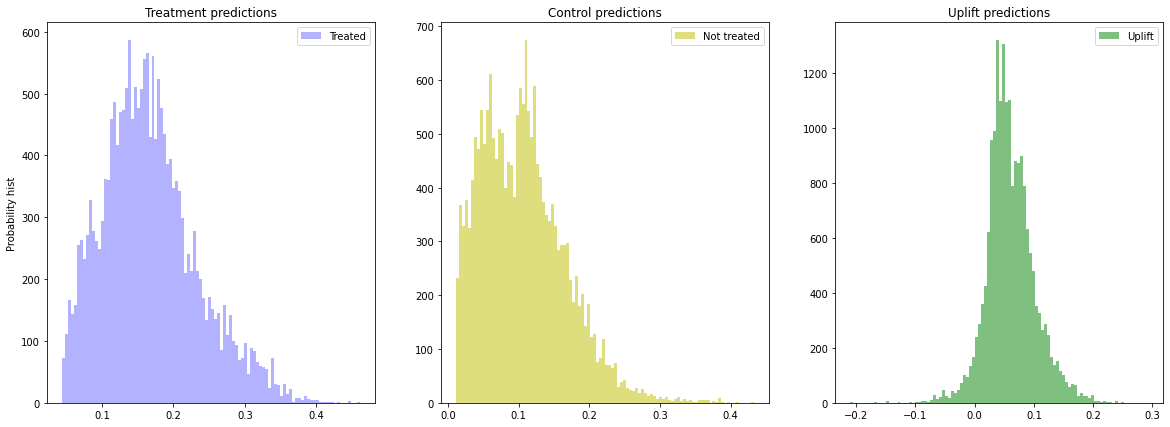

In [12]:
# Две независимые модели
tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)

tm = tm.fit(X_train, y_train, treat_train)

uplift_tm = tm.predict(X_test)

tm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.2)


models_results['name'].append('TwoModels')
models_results['uplift@10%'].append(tm_score_10)
models_results['uplift@20%'].append(tm_score_20)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

In [13]:
pd.DataFrame(data=models_results).sort_values('uplift@20%', ascending=False)

,name,uplift@10%,uplift@20%
1,ClassTransformation,0.248929,0.192901
0,SoloModel,0.092726,0.091203
2,TwoModels,0.080872,0.083763


### UpliftTreeClassifier

In [14]:
X_train_tree = X_train
features = [col for col in X_train_tree]

In [17]:
%%time
from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

uplift_model = UpliftTreeClassifier(max_depth=8, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train_tree.values,
                 treatment=treat_train.map({1: 'treatment', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
Image(graph.create_png())

ValueError: sklearn.tree._tree.TreeBuilder size changed, may indicate binary incompatibility. Expected 80 from C header, got 72 from PyObject